# Прогнозирование временного ряда выработки электроэнергии

Имеются два временных ряда: первый — это среднесуточная выработка электроэнергии ветряной установкой. 
Другой — среднесуточная выработка электроэнергии при помощи дизельного генератора. Оба показателя измеряются в кВт⋅ч.

Помимо данных двух временных рядов имеются временные ряды дополнительных параметров, таких как скорость ветра, температура воздуха и т.д.

Расшифровка представлена ниже (целевая переменная выделена жирным начертанием):

* datetime - День

* **diesel_fuel_kWh - Выработка эл.энергии ДЭС,  кВтч** 

* wind_power_kWh - Выработка эл.энергии ВЭУ,  кВтч

* diesel_time_h - Время работы дизельной электростанции (ДЭС),  ч

* wind_time_h - Время работы ветряной электроустановки (ВЭУ),  ч 

* velocity_max_msec - Скорость ветра (мах), м/с
 
* velocity_mean_msec - Скорость ветра (ср), м/с

* tmp_grad - Температура окр. среды (ср), град


Задача: построить модель, которая позволяет предсказывать значения временного ряда diesel_fuel_kWh на заданное количество суток вперёд. Таким образом, решается задача предсказания временного ряда.

Для решения задачи используется AutoML фреймворк FEDOT.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Additional custom functions
from processing import prepare_multimodal_data, plot_results, multi_automl_fit_forecast, plot_diesel_and_wind

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

Ниже представлен пример прогнозирования временного ряда на основе использования многомерных временных рядов

В рамках данного ноутбука будем варьировать размер обучающей выборки и длину прогнозирования.

## Вспомогательные функции

Реализуем функцию, которая будет запускать AutoML алгоритм. 

In [3]:
from remote.remote_fit import ComputationalSetup

def clip_dataframe(df, forecast_horizon, history_size):
    # Take last n elements from dataframe to train
    dataframe_cutted = df.tail(history_size+forecast_horizon)
    
    return dataframe_cutted

def run_automl(df: pd.DataFrame, features_to_use: list, target_series: str, 
               forecast_horizon: int = 10, history_size: int = 397, 
               timeout: int = 1):
    """ Launch AutoML FEDOT algorithm for time series forecasting task """

    ComputationalSetup.remote_eval_params = {
        'mode': 'remote',
        'dataset_name': 'pw_dataset',
        'task_type': f'Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length={forecast_horizon}))',
        'max_parallel': 20,
        'is_multi_modal': True,
        'var_names': features_to_use,
        'access_params': {
            'FEDOT_LOGIN': 'fedot',
            'FEDOT_PASSWORD': 'fedot-password',
            'AUTH_SERVER': 'http://10.32.0.51:30880/b',
            'CONTR_SERVER': 'http://10.32.0.51:30880/models-controller',
            'PROJECT_ID': '83',
            'DATA_ID': '60'
        }
    }

    dataframe_cutted = clip_dataframe(df, forecast_horizon, history_size)
    
    ts = np.array(dataframe_cutted[target_series])
    mm_train, mm_test, = prepare_multimodal_data(dataframe=dataframe_cutted,
                                                 features=features_to_use,
                                                 forecast_length=forecast_horizon)
    # Prepare parameters for algorithm launch
    # timeout 2 - means that AutoML algorithm will work for 2 minutes
    composer_params = {'max_depth': 6,
                       'max_arity': 3,
                       'pop_size': 20,
                       'num_of_generations': 100,
                       'timeout': timeout,
                       'preset': 'ultra_light',
                       'metric': 'rmse',
                       'cv_folds': None,
                       'validation_blocks': None}
    forecast, obtained_pipeline = multi_automl_fit_forecast(mm_train, mm_test,
                                                            composer_params,
                                                            ts, forecast_horizon,
                                                            vis=False)    
    
    return forecast, obtained_pipeline    


def plot_automl_forecast(df, forecast_horizon, history_size, forecast):
    dataframe_cutted = clip_dataframe(df, forecast_horizon, history_size)
    ts = np.array(dataframe_cutted[target_series])
    
    # Visualise predictions
    plot_results(actual_time_series=ts,
                 predicted_values=forecast,
                 len_train_data=len(ts) - forecast_horizon)
    
def print_metrics(df, forecast_horizon, history_size, forecast):
    dataframe_cutted = clip_dataframe(df, forecast_horizon, history_size)
    ts = np.array(dataframe_cutted[target_series])
    
    mse_metric = mean_squared_error(ts[-forecast_horizon:], forecast, squared=False)
    mae_metric = mean_absolute_error(ts[-forecast_horizon:], forecast)
    print(f'MAE - {mae_metric:.2f}')
    print(f'RMSE - {mse_metric:.2f}')

Загрузим датасет

In [4]:
df = pd.read_csv('pw_dataset.csv', parse_dates=['datetime'])

c:\users\николай\pycharmprojects\fedot-clone\venv\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\николай\pycharmprojects\fedot-clone\venv\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


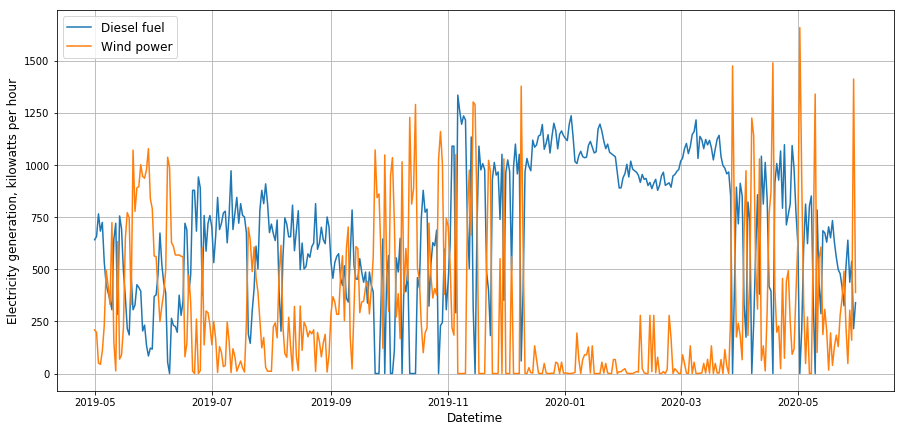

In [5]:
# Make visualisation
plot_diesel_and_wind(df)

Общее количество элементов в рядах: 397.

Определим целевой временной ряд и ряды, которые будут использовать как предикторы

In [6]:
features_to_use = ['wind_power_kWh', 'diesel_time_h', 'wind_time_h',
                   'velocity_max_msec', 'velocity_mean_msec', 'tmp_grad',
                   'diesel_fuel_kWh']
target_series = 'diesel_fuel_kWh'

## Запуск алгоритма для прогноза на 30 элементов, размер обучающей выборки 200, время работы 0.2 минуты

In [7]:
forecast, obtained_pipeline = run_automl(df=df, features_to_use=features_to_use, 
                                         target_series=target_series, 
                                         forecast_horizon=30,
                                         history_size=200,
                                         timeout=0.2)

Composition started. Parameters tuning: False. Set of candidate models: ['ar', 'dtreg', 'lasso', 'linear', 'ridge', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter', 'exog_ts_data_source']. Composing time limit: 0.2 min
Pipeline composition started
Remote fit used
[{'id': 2096, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:31.878385+00:00', 'updated_ts': '2021-09-17T19:00:47.336322+00:00', 'creator_id': 32}, {'id': 2099, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:33.18114

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

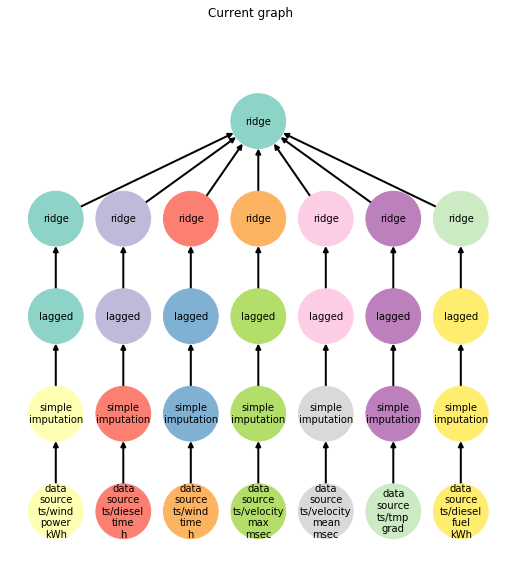

In [8]:
obtained_pipeline.show()

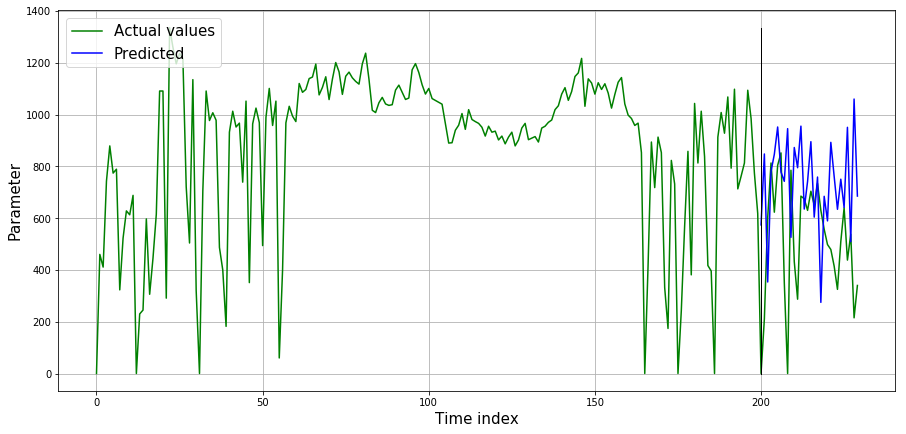

In [9]:
plot_automl_forecast(df, forecast_horizon=30, history_size=200, forecast=forecast)

In [10]:
print_metrics(df, forecast_horizon=30, history_size=200, forecast=forecast)

MAE - 292.84
RMSE - 376.89


## Запуск алгоритма для прогноза на 60 элементов, размер обучающей выборки 300, время работы 2 минуты

In [11]:
forecast_horizon = 60
history_size=300
timeout=2
forecast, obtained_pipeline = run_automl(df=df, features_to_use=features_to_use, 
                                         target_series=target_series, 
                                         forecast_horizon=forecast_horizon,
                                         history_size=history_size,
                                         timeout=timeout)

Composition started. Parameters tuning: False. Set of candidate models: ['ar', 'dtreg', 'lasso', 'linear', 'ridge', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter', 'exog_ts_data_source']. Composing time limit: 2 min
Pipeline composition started
Remote fit used
[{'id': 2096, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:31.878385+00:00', 'updated_ts': '2021-09-17T19:00:47.336322+00:00', 'creator_id': 32}, {'id': 2099, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:33.181147+

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

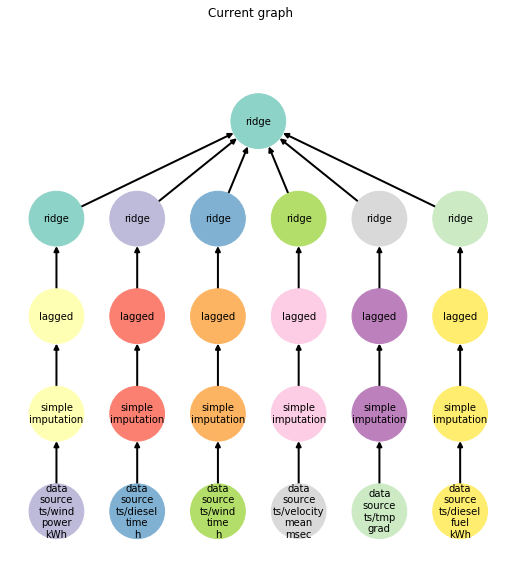

In [12]:
obtained_pipeline.show()

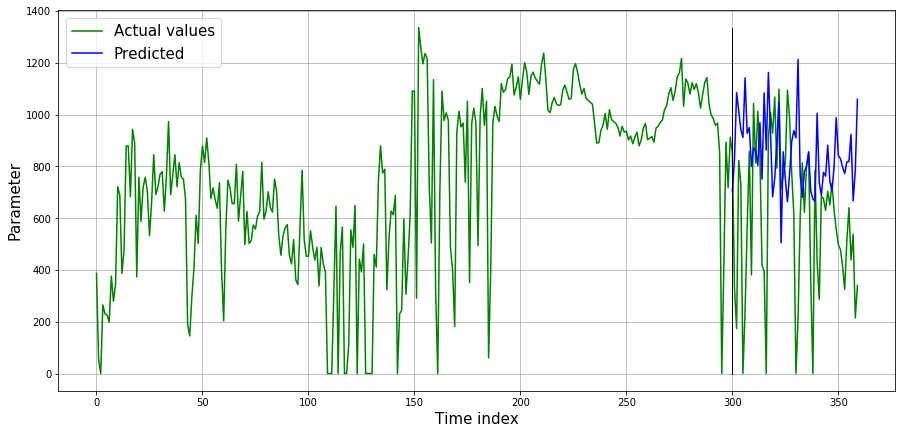

In [13]:
plot_automl_forecast(df, forecast_horizon, history_size, forecast=forecast)

In [14]:
print_metrics(df, forecast_horizon, history_size, forecast=forecast)

MAE - 319.45
RMSE - 414.59


## Пример с запуском на одном признаке (на том же самом временном ряду)

In [ ]:
forecast_horizon = 60
history_size=300
timeout=2
features_to_use = ['diesel_fuel_kWh']
forecast, obtained_pipeline = run_automl(df=df, features_to_use=features_to_use, 
                                         target_series=target_series, 
                                         forecast_horizon=forecast_horizon,
                                         history_size=history_size,
                                         timeout=timeout)

Composition started. Parameters tuning: False. Set of candidate models: ['ar', 'dtreg', 'lasso', 'linear', 'ridge', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter', 'exog_ts_data_source']. Composing time limit: 2 min
Pipeline composition started
Remote fit used
[{'id': 2096, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:31.878385+00:00', 'updated_ts': '2021-09-17T19:00:47.336322+00:00', 'creator_id': 32}, {'id': 2099, 'group_id': 145, 'image': 'fedot:dm-6', 'input_path': '/home/FEDOT/input_data_dir', 'output_path': '/home/FEDOT/output_data_dir', 'config_path': '/home/FEDOT/.config', 'timeout': 360, 'status': 'Succeeded', 'created_ts': '2021-09-17T19:00:33.181147+

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

['2096=Succeeded;', '2099=Succeeded;', '2100=Succeeded;', '2101=Succeeded;', '2102=Succeeded;', '2116=Succeeded;', '2118=Succeeded;', '2119=Succeeded;', '2095=Succeeded;', '2097=Succeeded;', '2098=Succeeded;', '2107=Succeeded;', '2108=Succeeded;', '2112=Succeeded;', '2114=Succeeded;', '2115=Succeeded;', '2123=Succeeded;', '2103=Succeeded;', '2104=Succeeded;', '2105=Succeeded;', '2106=Succeeded;', '2109=Succeeded;', '2110=Succeeded;', '2111=Succeeded;', '2113=Succeeded;', '2094=Succeeded;', '2124=Succeeded;', '2117=Succeeded;', '2126=Succeeded;', '2125=Succeeded;', '2120=Succeeded;', '2160=Succeeded;', '2162=Succeeded;', '2180=Succeeded;', '2157=Succeeded;', '2158=Succeeded;', '2171=Succeeded;', '2132=Succeeded;', '2134=Succeeded;', '2135=Succeeded;', '2137=Succeeded;', '2139=Succeeded;', '2141=Succeeded;', '2182=Succeeded;', '2146=Succeeded;', '2183=Succeeded;', '2148=Succeeded;', '2149=Succeeded;', '2152=Succeeded;', '2153=Succeeded;', '2155=Succeeded;', '2184=Succeeded;', '2185=Succe

In [ ]:
obtained_pipeline.show()

In [ ]:
plot_automl_forecast(df, forecast_horizon, history_size, forecast=forecast)

In [ ]:
print_metrics(df, forecast_horizon, history_size, forecast=forecast)